# Performing differential expression analysis with AlphaQuant and investigating the results

Below some code how to perform differential expression testing with AlphaQuant. This means we do a pairwise comparison of biological conditions and some volcano plot visualizations.

## Specifying input files

In order to run differential analyses you need:
* an input file from a proteomics search engine (e.g. DIA-NN, Spectronaut, AlphaPept etc.), or a pre-formatted file
* a sample mapping file that maps each sample to a condition (e.g.  sample 'brain_replicate_1' is mapped to condition 'brain'). In the GUI, there is some functionality to help create such a file
* (optional) a results directory can be defined on where to save the data
* (optional) a list where we specify, which conditions we compare

AlphaQuant is compatible to the default output tables of most common proteomics search engines. Detailed specifications on which tables you need can be found 
in our  [README](https://github.com/MannLabs/alphaquant/blob/main/README.md#section-title).


In [1]:
INPUT_FILE = "./data/mouse_tissues/mouse_tissues_100prot_200ng.aq_reformat.tsv" 
SAMPLEMAP_FILE = "./data/mouse_tissues/samplemap_200.tsv"
CONDPAIRS_TO_COMPARE = [('spleen', 'testis'), ('lungs', 'brain')]
RESULTS_DIRECTORY = "./data/mouse_tissues/results_pairwise_analysis"

In [2]:
#displaying the samplemap file
import pandas as pd
display(pd.read_csv(SAMPLEMAP_FILE, sep='\t'))


,sample,condition
0,20230926_OA2_CaWe_aQuant_mBrain_200ng_01.raw,brain
1,20230926_OA2_CaWe_aQuant_mBrain_200ng_02.raw,brain
2,20230926_OA2_CaWe_aQuant_mBrain_200ng_03.raw,brain
3,20230926_OA2_CaWe_aQuant_mBrain_200ng_04.raw,brain
4,20230926_OA2_CaWe_aQuant_mBrain_200ng_05.raw,brain
...,...,...
74,20230926_OA2_CaWe_aQuant_mTestis_200ng_06.raw,testis
75,20230926_OA2_CaWe_aQuant_mTestis_200ng_07.raw,testis
76,20230926_OA2_CaWe_aQuant_mTestis_200ng_08.raw,testis
77,20230926_OA2_CaWe_aQuant_mTestis_200ng_09.raw,testis


## Run AlphaQuant in pairwise-comparison mode

Now we can use the 'run_pipeline' command from AlphaQuant. This performs normalization between sample and then differential expression testing. The main output is a table of proteins with fold changes and an fdr value as a result of the differential expression test. Due to AlphaQuant's tree based approach, sensitivity is in general higher as compared to standard approaches like the t-test, i.e. there should be more proteins with significant fdr, especially for lower fold changes.

In [3]:
import alphaquant.run_pipeline as aq_pipeline

aq_pipeline.run_pipeline(input_file=INPUT_FILE, samplemap_file=SAMPLEMAP_FILE, 
                         condpairs_list=CONDPAIRS_TO_COMPARE, results_dir=RESULTS_DIRECTORY, runtime_plots=False, cluster_threshold_pval=0.2, take_median_ion=True)

start processeing condpair ('spleen', 'testis')
normalized within conditions
median -0.8106630368583518, mode -0.8282891052920638
using median for shift
shift comparison by 0.8106630368583518
normalized between conditions
t_ion2nonan_sw 0.006303071975708008
t_intensity_selection 0.18559002876281738
t_ion2nonan_sw 0.00647282600402832
t_intensity_selection 0.17574000358581543
checked 0 of 2783 ions
checked 2000 of 2783 ions
checked 0 of 100 prots

condition pair ('spleen', 'testis') finished!

start processeing condpair ('lungs', 'brain')
normalized within conditions
median -0.2582211316884333, mode -0.0907526108990453
using mode for shift
shift comparison by 0.0907526108990453
normalized between conditions
t_ion2nonan_sw 0.006455183029174805
t_intensity_selection 0.17936015129089355
t_ion2nonan_sw 0.0063321590423583984
t_intensity_selection 0.1741950511932373
checked 0 of 2783 ions
checked 2000 of 2783 ions
checked 0 of 100 prots

condition pair ('lungs', 'brain') finished!



## Inspecting output tables

The main output tables for each pairwise comparison are located in the results folder and are named
 * spleen_VS_testis.results.tsv
 * lungs_VS_brain.results.tsv

Let's load one of them:
 
 

In [4]:
import pandas as pd

df_spleen_testis  = pd.read_csv(RESULTS_DIRECTORY + "/spleen_VS_testis.results.tsv", sep='\t')
display(df_spleen_testis)

,condition_pair,protein,p_value,log2fc,number_of_ions,quality_score,total_intensity,num_peptides,fdr
0,spleen_VS_testis,Q6PCP5,2.497260e-05,0.912469,3,0.009153,3.390250e+02,1,3.901969e-05
1,spleen_VS_testis,P24527,4.280971e-16,1.956959,84,0.285846,1.457586e+07,13,2.608185e-15
2,spleen_VS_testis,P05064,8.292273e-01,0.175870,160,0.358910,4.294959e+07,15,8.745229e-01
3,spleen_VS_testis,P53810,1.735171e-15,1.913031,15,0.057780,2.241204e+06,2,5.075305e-15
4,spleen_VS_testis,P61202,1.588902e-01,0.177882,46,0.153317,2.824344e+06,7,1.869297e-01
...,...,...,...,...,...,...,...,...,...
95,spleen_VS_testis,A2ALF0;Q6NZB0,2.220446e-16,2.035300,3,0.009153,2.254687e+05,1,2.467162e-15
96,spleen_VS_testis,Q8K1R7,3.477219e-13,1.907509,2,0.004577,5.561103e+02,1,7.727152e-13
97,spleen_VS_testis,Q8VE47,2.542846e-10,0.948651,3,0.009153,3.382982e+05,1,4.797823e-10
98,spleen_VS_testis,Q9JLN9,5.135994e-01,0.422655,2,0.004577,5.334778e+05,1,5.836357e-01


The fold changes are defined as condition1 - condition2. For example spleen_VS_testis means that a log2fc is calculated by log2(intensity_spleen/intensity_testis)

In [5]:
df_spleen_testis["abs_fc"] = abs(df_spleen_testis["log2fc"])
display(df_spleen_testis.sort_values(by='abs_fc').iloc[:15])

,condition_pair,protein,p_value,log2fc,number_of_ions,quality_score,total_intensity,num_peptides,fdr,abs_fc
76,spleen_VS_testis,Q9CQ60,0.984024,-0.013817,10,0.041190,1.613836e+06,2,0.993063,0.013817
94,spleen_VS_testis,P08207,0.942208,-0.032589,4,0.013730,2.304937e+06,1,0.961437,0.032589
78,spleen_VS_testis,Q9DD18,0.906962,0.043871,2,0.004577,5.663954e+02,1,0.935012,0.043871
40,spleen_VS_testis,P58281-2,0.824074,0.051160,85,0.291815,3.132543e+06,14,0.874523,0.051160
58,spleen_VS_testis,O08547,0.830797,-0.057373,29,0.111556,3.969391e+06,5,0.874523,0.057373
18,spleen_VS_testis,Q9WUM5,0.993063,-0.060973,41,0.142019,4.314561e+06,4,0.993063,0.060973
11,spleen_VS_testis,A0A1D5RLW5;A0A1D5RM85;P62717,0.080235,-0.098215,15,0.058352,4.258287e+06,2,0.095518,0.098215
16,spleen_VS_testis,P11499,0.856386,-0.098788,267,1.000000,4.265103e+08,23,0.892069,0.098788
33,spleen_VS_testis,Q8R5L1,0.045919,-0.108725,22,0.090516,1.889162e+07,3,0.055324,0.108725
65,spleen_VS_testis,D3Z645;Q9QZ88,0.041266,0.112879,32,0.112585,2.594877e+06,5,0.050324,0.112879


## Visualizing results - basic plots

### Volcano plot

(<Figure size 400x400 with 1 Axes>,
 <AxesSubplot:title={'center':'45 up, 24 down of 100'}, xlabel='log2(FC)', ylabel='-log10(fdr)'>)

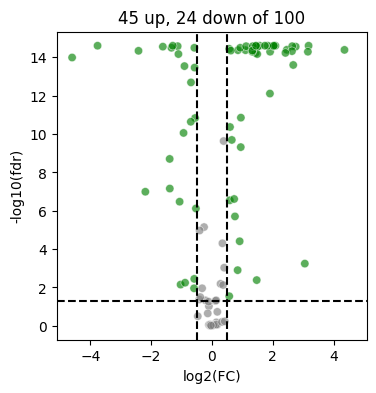

In [6]:
import alphaquant.plotting.pairwise as aq_plotting_pairwise

aq_plotting_pairwise.volcano_plot(df_spleen_testis)

### Normalization plot

The normalization plot gives the foldchanges between a given sample and the median over all samples. The peak of the distributions should be centered around 0. If not, there might be a problem with the normalization.

In [7]:
normalized_df = pd.read_csv(RESULTS_DIRECTORY + "/spleen_VS_testis.normed.tsv", sep='\t')
samplemap_df = pd.read_csv(SAMPLEMAP_FILE, sep='\t')

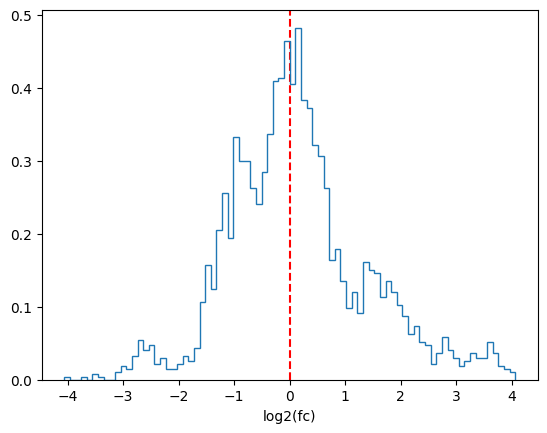

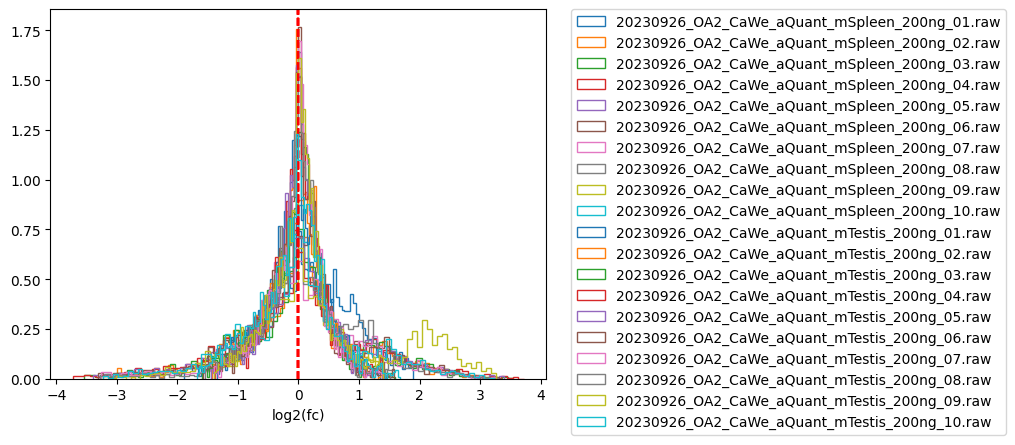

In [8]:
aq_plotting_pairwise.plot_normalization_overview(normalized_df, samplemap_df)

## Inspect and visualize proteoforms

Peptides that show different quantititative behaviour than other peptides can indicate proteoforms. The logic behind this can be elucidated with a simple example. Let's assume we have a protein with 3 peptides in spleen and testis. The protein itself shows no regulation between the two tissues. Therefore, we can expect that neither of the peptides changes between the conditions. The log2 fold changes for all the peptides should be the same. Now, let's assume that one of the peptides is phosphorylated in testis. If fifty percent of the copies of this peptide carry a phosphorylation, then only half as much **non-modified** peptide should be detectable in testis. This means, that in out spleen_vs_testis condition, we expect the unmodified version of the phosphorylated peptide to be up-regulated, while the other peptides have no regulation. The fold changes should differ. With AlphaQuant, we can investigate systematic differences between fold changes and report peptides that behave differently than expected.

We write out a `.proteoforms.tsv` table for each pair of conditions. Let's load the one for spleen and testis:

In [9]:
import pandas as pd
proteoform_df = pd.read_csv(RESULTS_DIRECTORY + "/spleen_VS_testis.proteoforms.tsv", sep='\t')
display(proteoform_df)

,protein,proteoform_id,cluster,is_reference,peptides,num_peptides,quality_score,log2fc,fraction_of_peptides,fcdiff
0,A0A0A0MQM0;P63242,A0A0A0MQM0;P63242_0,0,True,SEQ_EDLRLPEGDLGK_;SEQ_VHLVGIDIFTGK_;SEQ_RNDFQL...,3,0.901235,-0.167828,1.00,0.000000
1,A0A0R4J1N9;P40630;P40630-2,A0A0R4J1N9;P40630;P40630-2_0,0,True,SEQ_SAYNIYVSESFQEAK_;SEQ_FSTEQLPK_;SEQ_SWEEQMA...,5,0.259259,0.319808,1.00,0.000000
2,A0A0R4J2B2;Q6WVG3,A0A0R4J2B2;Q6WVG3_0,0,True,SEQ_YILDYLR_;SEQ_FNFLEQAFDK_,2,0.111111,2.640351,0.67,0.000000
3,A0A0R4J2B2;Q6WVG3,A0A0R4J2B2;Q6WVG3_1,1,False,SEQ_MFTQQQPQELAR_,1,0.061728,3.213556,0.33,0.573205
4,A0A1B0GRR3;P62281,A0A1B0GRR3;P62281_0,0,True,SEQ_EAIEGTYIDK_;SEQ_DYLHYIR_,2,0.308642,-0.568436,0.67,0.000000
...,...,...,...,...,...,...,...,...,...,...
112,Q9WTL7,Q9WTL7_0,0,True,SEQ_FGALTAEK_;SEQ_ETAAVIFLHGLGDTGHSWADALSTIR_,2,0.135802,1.329673,1.00,0.000000
113,Q9WUM5,Q9WUM5_0,0,True,SEQ_HLGLPVFNTVK_;SEQ_QGTFHSQQALEYGTK_;SEQ_PVVS...,4,0.483539,-0.019537,1.00,0.000000
114,Q9WVA2,Q9WVA2_0,0,True,SEQ_SKPVFSESLSD_;SEQ_FIDTSQFILNR_,2,0.308642,-0.257475,1.00,0.000000
115,Q9Z0N1,Q9Z0N1_0,0,True,SEQ_HILILQNK_;SEQ_QATINIGTIGHVAHGK_;SEQ_IVSLFA...,5,0.358025,-0.725947,0.71,0.000000


An important column is termed "fcdiff", which quantifies the fold change difference between peptides and groups of peptides. Let's filter for proteoforms with a log2 fold change difference of at least 0.7, using an AlphaQuant function:

In [10]:
import alphaquant.utils.diffquant_utils as aq_diffquant_utils

proteoform_df_filtered = aq_diffquant_utils.filter_proteoform_df(proteoform_df=proteoform_df, min_num_peptides=1, fcdiff_cutoff=0.5)
display(proteoform_df_filtered)

,protein,proteoform_id,cluster,is_reference,peptides,num_peptides,quality_score,log2fc,fraction_of_peptides,fcdiff
3,A0A0R4J2B2;Q6WVG3,A0A0R4J2B2;Q6WVG3_1,1,False,SEQ_MFTQQQPQELAR_,1,0.061728,3.213556,0.33,0.573205
5,A0A1B0GRR3;P62281,A0A1B0GRR3;P62281_1,1,False,SEQ_VLLGETGK_,1,0.127572,-0.013920,0.33,0.554516
16,D3Z041;P41216,D3Z041;P41216_1,1,False,SEQ_LLVYYYDDVR_;SEQ_LVDVEEMNYLASK_,2,0.229630,-5.277730,0.15,0.600995
31,P05064,P05064_1,1,False,SEQ_LQSIGTENTEENRR_;SEQ_LQSIGTENTEENR_;SEQ_ELS...,5,0.456790,0.672379,0.33,0.567427
38,P11499,P11499_1,1,False,SEQ_EDQTEYLEERR_,1,0.209877,0.807947,0.04,0.827309
69,Q71RI9;Q71RI9-2,Q71RI9;Q71RI9-2_1,1,False,SEQ_AIILNTPHNPLGK_,1,0.028807,-2.208015,0.50,0.824153
83,Q8VDQ1,Q8VDQ1_1,1,False,SEQ_TGNVAEQLR_,1,0.252675,0.597725,0.20,0.772662
88,Q922B2,Q922B2_1,1,False,SEQ_NNAYLAQSPQLYK_;SEQ_QSNSYDMFMR_;SEQ_IYVISLA...,5,0.358025,-0.405384,0.38,0.532747
91,Q99LC3,Q99LC3_1,1,False,SEQ_EIAQQLGMK_,1,0.265432,-0.414809,0.10,0.526525
92,Q99LC3,Q99LC3_2,2,False,SEQ_VVEDIEYLK_,1,0.111111,0.415395,0.10,1.356729


This leaves only a few proteins of interest. Let's visualize them in order to check them out further. For this we must load a few modules in AlphaQuant:

[<Figure size 150x1000 with 1 Axes>,
 <Figure size 150x1000 with 1 Axes>,
 <Figure size 650x1000 with 1 Axes>,
 <Figure size 750x1000 with 1 Axes>,
 <Figure size 1150x1000 with 1 Axes>,
 <Figure size 100x1000 with 1 Axes>,
 <Figure size 250x1000 with 1 Axes>,
 <Figure size 650x1000 with 1 Axes>,
 <Figure size 500x1000 with 1 Axes>,
 <Figure size 150x1000 with 1 Axes>,
 <Figure size 350x1000 with 1 Axes>]

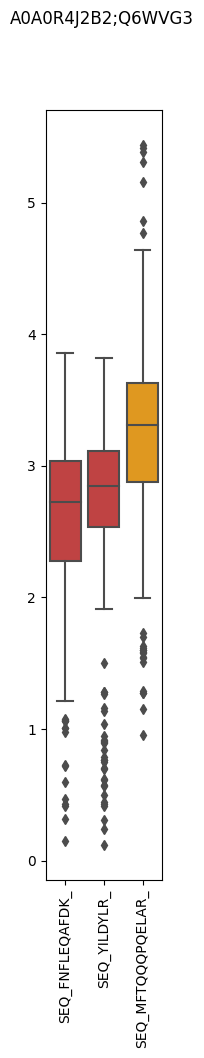

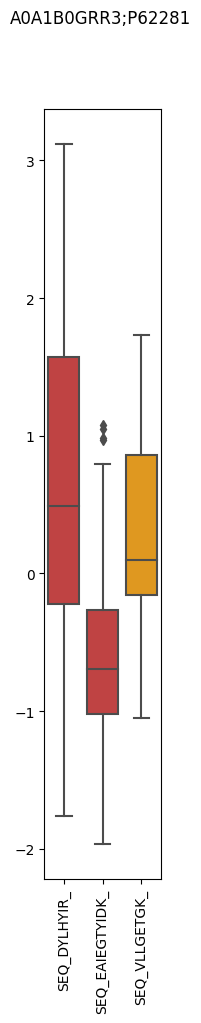

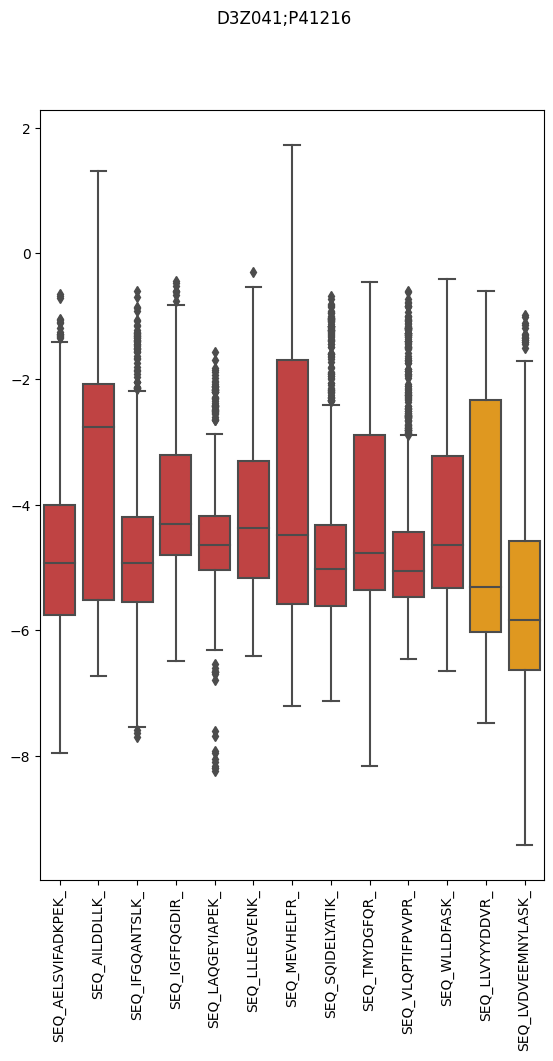

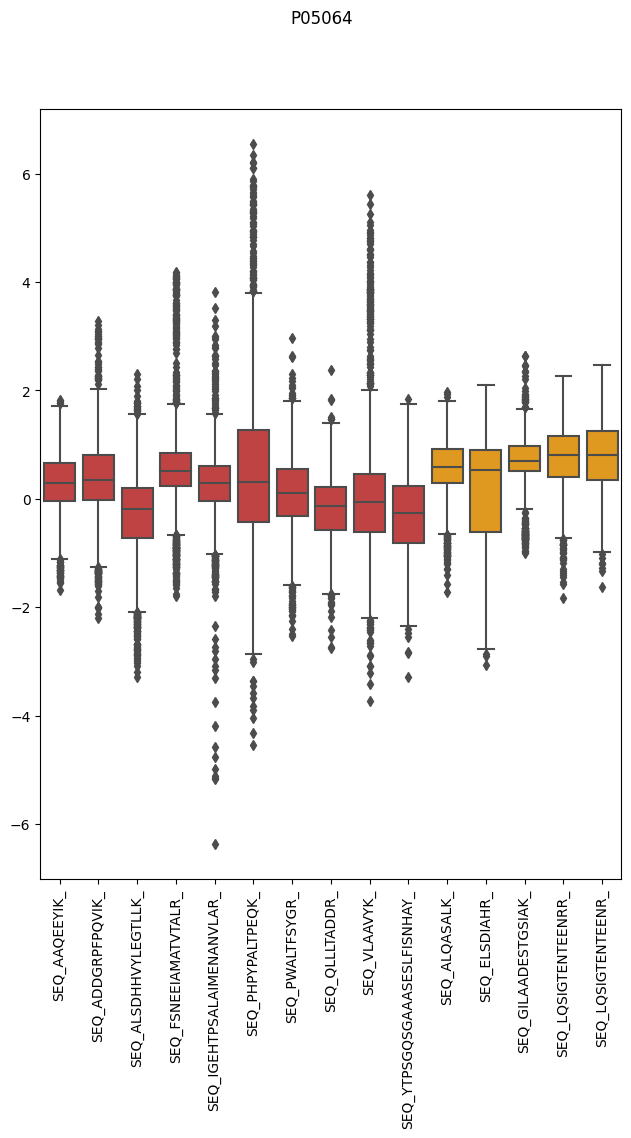

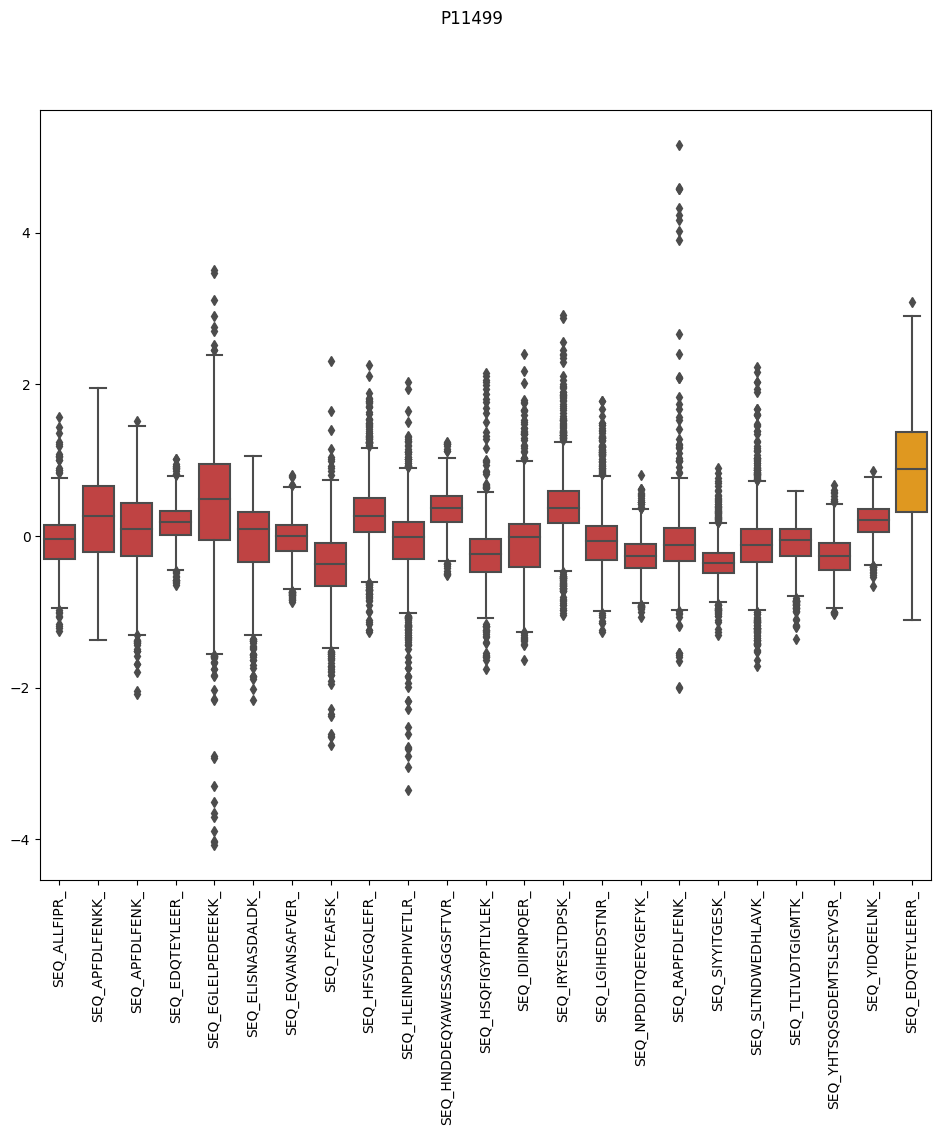

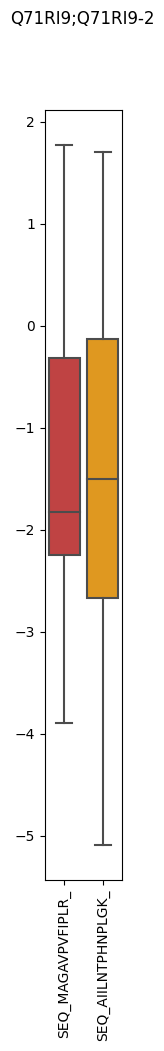

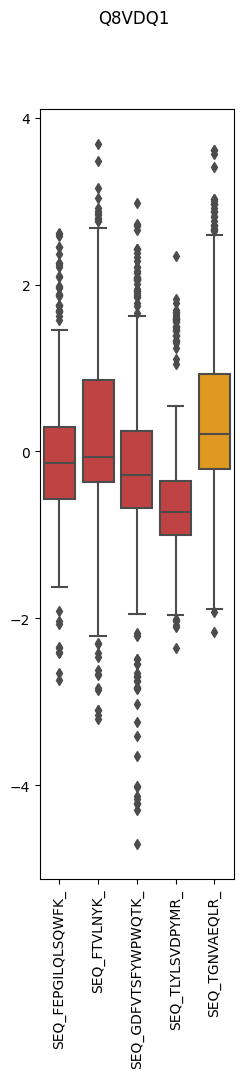

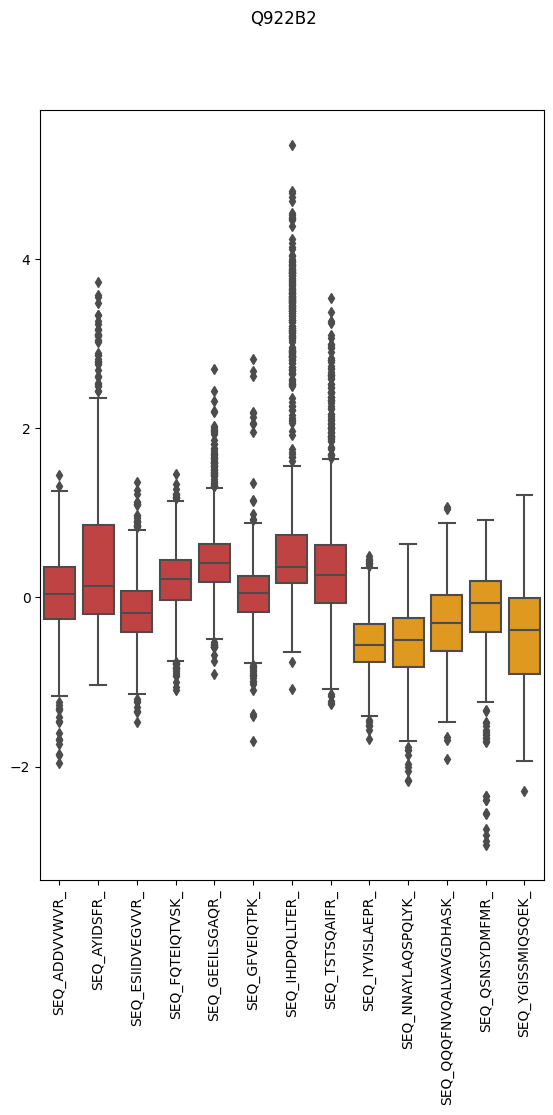

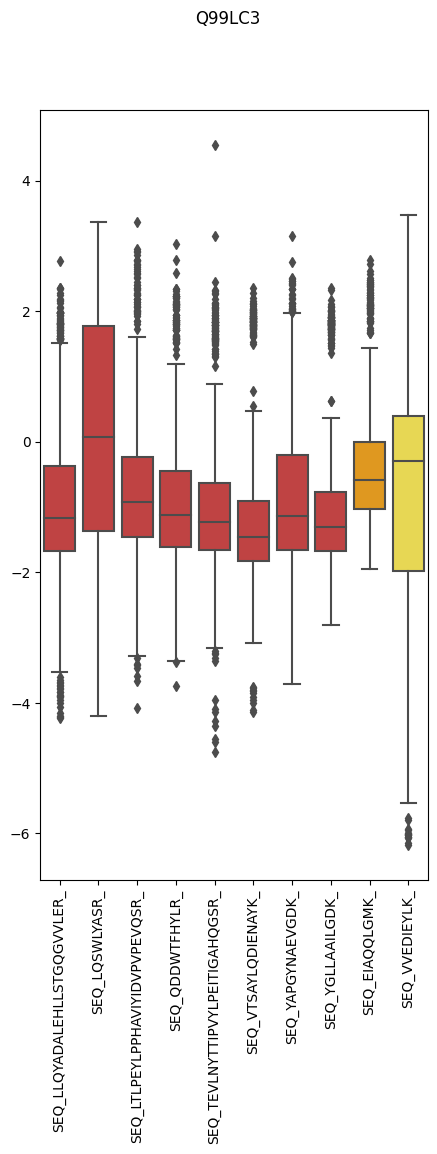

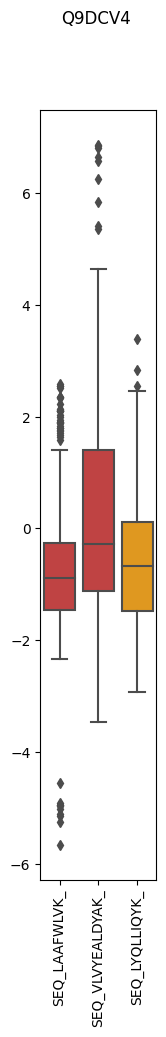

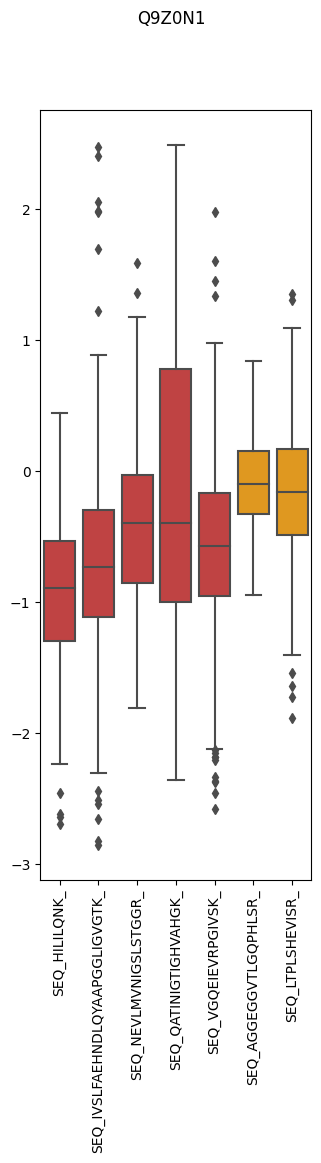

In [11]:
import alphaquant.plotting.fcviz as aq_plot_fc
# import alphaquant.plotting.base_functions as aq_base_functions
# import alphaquant.utils.utils as aq_utils

# plotconfig = aq_fcviz.PlotConfig()
# plotconfig.colorlist = aq_base_functions.AlphaPeptColorMap().colorlist #change the colorlist to the AlphaPept colorlist, not necessary

# quantification_info = aq_fcviz.CondpairQuantificationInfo(("spleen", "testis"), RESULTS_DIRECTORY, SAMPLEMAP_FILE)

# #load the trees containing the tree-based quantification info
# condpair_tree = aq_utils.read_condpair_tree("spleen", "testis", results_folder=RESULTS_DIRECTORY)

# protein2node = {x.name : x for x in condpair_tree.children}
# for protein_of_interest in proteoform_df_filtered['protein'].unique():
#     print(protein_of_interest)
#     protein_node = protein2node[protein_of_interest]
#     cluster_plotter = aq_fcviz.FCPlotter(protein_node, quantification_info, plotconfig)
        
protein_of_interest = proteoform_df_filtered['protein'].unique()
fc_visualizer = aq_plot_fc.FoldChangeVisualizer(condition1="spleen", condition2="testis", results_directory=RESULTS_DIRECTORY, samplemap_file=SAMPLEMAP_FILE)

fc_visualizer.plot_list_of_proteins(protein_of_interest)

Of those potential candidates, P11499 looks very consistent, let's investigate it further, using visualizations of the AlphaMap package, for this we first need to install it:

In [12]:
!pip install --no-deps alphamap

In [13]:
import alphaquant.plotting.alphamapviz as aq_plot_alphamap

amap_visualizer = aq_plot_alphamap.AlphaMapVisualizer(condition1="spleen", condition2="testis", results_directory=RESULTS_DIRECTORY, samplemap_file=SAMPLEMAP_FILE,protein_identifier='uniprot_id', organism="Mouse") #because we need to map the protein to it's respective sequence, we need to specify that the protein identidier is uniprot and the organism is Mouse

/Users/constantin/opt/anaconda3/envs/test/lib/python3.8/site-packages/alphamap/organisms_data.py:135: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  uniprot_file = pd.read_csv(os.path.join(DATA_PATH, uniprot_name))


/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_33714/2945110299.py:3: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



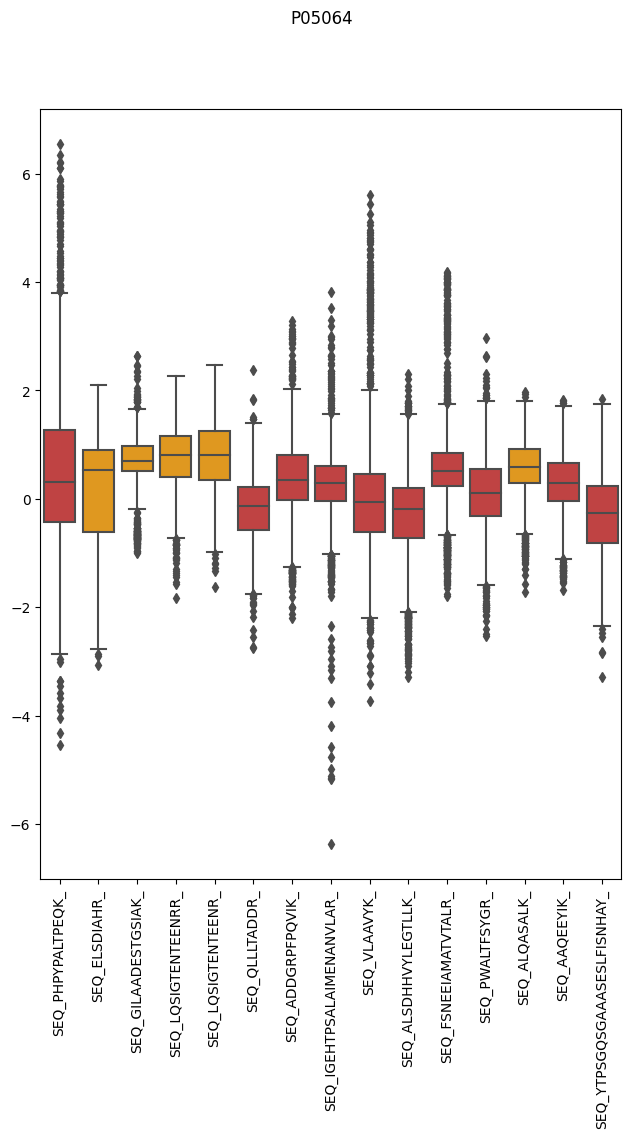

In [14]:
fc_fig, alphamap_go_fig = amap_visualizer.visualize_protein("P05064")

fc_fig.show()
alphamap_go_fig.show()

Inspecting the peptides aligned along the proteoform, we see that cluster 0 peptides map to many modified residues, indicating phosphorylation of the protein. In particular, we see that the putatively phosphorylated peptides in cluster 1 show less downregulation than the unphosphorylated peptides. As we test spleen minus testis, this means that the testis sample has likely higher phosphorylation and therefore less of the native peptide.